## 1. 분석 환경 및 데이터 로드

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

plt.rcParams['font.family'] = 'AppleGothic'  # Mac 한글 폰트
plt.rcParams['axes.unicode_minus'] = False

In [76]:
# SQLite 연결
conn = sqlite3.connect('../olist.sqlite')

# 주요 테이블 로드
orders = pd.read_sql_query("SELECT * FROM orders", conn)
order_items = pd.read_sql_query("SELECT * FROM order_items", conn)
customers = pd.read_sql_query("SELECT * FROM customers", conn)
order_payments = pd.read_sql_query("SELECT * FROM order_payments", conn)
products = pd.read_sql_query("SELECT * FROM products", conn)

In [77]:
# 데이터 row 수, 컬럼 확인
tables = {'orders': orders, 'order_items': order_items, 'customers': customers, 
          'order_payments': order_payments, 'products': products}

for name, df in tables.items():
    print(f"\n=== {name} ===")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(df.dtypes)


=== orders ===
Shape: (99441, 8)
Columns: ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

=== order_items ===
Shape: (112650, 7)
Columns: ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']
order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

=== customers ===
Shape: (99441, 5)
Columns: 

## 2. 테이블 구조 및 관계 확인

In [78]:
# PK 후보 식별: 고유값 수 vs 전체 row 수 비교
print("=== Primary Key 후보 식별 ===")
print(f"orders.order_id 고유값: {orders['order_id'].nunique()} / 전체: {len(orders)}")
print(f"customers.customer_id 고유값: {customers['customer_id'].nunique()} / 전체: {len(customers)}")
print(f"customers.customer_unique_id 고유값: {customers['customer_unique_id'].nunique()} / 전체: {len(customers)}")
print(f"products.product_id 고유값: {products['product_id'].nunique()} / 전체: {len(products)}")

=== Primary Key 후보 식별 ===
orders.order_id 고유값: 99441 / 전체: 99441
customers.customer_id 고유값: 99441 / 전체: 99441
customers.customer_unique_id 고유값: 96096 / 전체: 99441
products.product_id 고유값: 32951 / 전체: 32951


In [79]:
# 테이블 간 관계: 1:N 확인
print("=== 테이블 간 관계 ===")
print(f"order_items per order_id: {order_items.groupby('order_id').size().describe()}")
print(f"\norder_payments per order_id: {order_payments.groupby('order_id').size().describe()}")

=== 테이블 간 관계 ===
order_items per order_id: count    98666.000000
mean         1.141731
std          0.538452
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         21.000000
dtype: float64

order_payments per order_id: count    99440.000000
mean         1.044710
std          0.381166
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         29.000000
dtype: float64


In [80]:
# JOIN 시 중복 발생 지점 확인
print("=== JOIN 시 row 증가 확인 ===")
print(f"orders row 수: {len(orders)}")
merged = orders.merge(order_items, on='order_id', how='left')
print(f"orders + order_items JOIN 후 row 수: {len(merged)}")
print(f"증가 비율: {len(merged) / len(orders):.2f}배")

=== JOIN 시 row 증가 확인 ===
orders row 수: 99441
orders + order_items JOIN 후 row 수: 113425
증가 비율: 1.14배


## 3. 핵심 컬럼 탐색

In [81]:
# 날짜 컬럼 분포
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
print("=== 날짜 범위 ===")
print(f"min: {orders['order_purchase_timestamp'].min()}")
print(f"max: {orders['order_purchase_timestamp'].max()}")
print(f"\n월별 주문 수:")
print(orders['order_purchase_timestamp'].dt.to_period('M').value_counts().sort_index())

=== 날짜 범위 ===
min: 2016-09-04 21:15:19
max: 2018-10-17 17:30:18

월별 주문 수:
order_purchase_timestamp
2016-09       4
2016-10     324
2016-12       1
2017-01     800
2017-02    1780
2017-03    2682
2017-04    2404
2017-05    3700
2017-06    3245
2017-07    4026
2017-08    4331
2017-09    4285
2017-10    4631
2017-11    7544
2017-12    5673
2018-01    7269
2018-02    6728
2018-03    7211
2018-04    6939
2018-05    6873
2018-06    6167
2018-07    6292
2018-08    6512
2018-09      16
2018-10       4
Freq: M, Name: count, dtype: int64


In [82]:
# 범주형 컬럼 값 확인
print("=== order_status ===")
print(orders['order_status'].value_counts())

print("\n=== payment_type ===")
print(order_payments['payment_type'].value_counts())

print("\n=== customer_state (상위 10개) ===")
print(customers['customer_state'].value_counts().head(10))

=== order_status ===
order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

=== payment_type ===
payment_type
credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: count, dtype: int64

=== customer_state (상위 10개) ===
customer_state
SP    41746
RJ    12852
MG    11635
RS     5466
PR     5045
SC     3637
BA     3380
DF     2140
ES     2033
GO     2020
Name: count, dtype: int64


In [83]:
# NULL 비율 점검
print("=== NULL 비율 ===")
for name, df in tables.items():
    null_pct = (df.isnull().sum() / len(df) * 100).round(2)
    null_cols = null_pct[null_pct > 0]
    if len(null_cols) > 0:
        print(f"\n{name}:")
        print(null_cols)

=== NULL 비율 ===

orders:
order_approved_at                0.16
order_delivered_carrier_date     1.79
order_delivered_customer_date    2.98
dtype: float64

products:
product_category_name         1.85
product_name_lenght           1.85
product_description_lenght    1.85
product_photos_qty            1.85
product_weight_g              0.01
product_length_cm             0.01
product_height_cm             0.01
product_width_cm              0.01
dtype: float64


## 4. 분석 전제 검증

In [84]:
# order_status별 주문 분포
status_dist = orders['order_status'].value_counts()
status_pct = (status_dist / len(orders) * 100).round(2)
print("=== order_status 분포 ===")
print(pd.DataFrame({'count': status_dist, 'pct': status_pct}))

=== order_status 분포 ===
              count    pct
order_status              
delivered     96478  97.02
shipped        1107   1.11
canceled        625   0.63
unavailable     609   0.61
invoiced        314   0.32
processing      301   0.30
created           5   0.01
approved          2   0.00


In [85]:
# delivered 주문만 사용 시 제외되는 주문 비율
delivered_count = len(orders[orders['order_status'] == 'delivered'])
excluded_pct = (1 - delivered_count / len(orders)) * 100
print(f"delivered 주문: {delivered_count} ({delivered_count/len(orders)*100:.2f}%)")
print(f"제외되는 주문 비율: {excluded_pct:.2f}%")

delivered 주문: 96478 (97.02%)
제외되는 주문 비율: 2.98%


In [86]:
# 하나의 주문에 여러 item / payment 레코드 존재 여부
print("=== 주문당 item 수 분포 ===")
print(order_items.groupby('order_id').size().value_counts().head(10))

print("\n=== 주문당 payment 수 분포 ===")
print(order_payments.groupby('order_id').size().value_counts().head(10))

=== 주문당 item 수 분포 ===
1     88863
2      7516
3      1322
4       505
5       204
6       198
7        22
8         8
10        8
12        5
Name: count, dtype: int64

=== 주문당 payment 수 분포 ===
1     96479
2      2382
3       301
4       108
5        52
6        36
7        28
8        11
9         9
11        8
Name: count, dtype: int64


## 5. SQL 분석 결과 검증용 계산

In [87]:
# delivered 주문 필터링
delivered_orders = orders[orders['order_status'] == 'delivered'][['order_id', 'order_purchase_timestamp']]

# GMV 계산: SUM(price + freight_value)
order_items_gmv = order_items.merge(delivered_orders, on='order_id', how='inner')
order_items_gmv['gmv'] = order_items_gmv['price'] + order_items_gmv['freight_value']

total_gmv = order_items_gmv['gmv'].sum()
print(f"전체 GMV (delivered): {total_gmv:,.2f}")

전체 GMV (delivered): 15,419,773.75


In [88]:
# 주문 단위 GMV
order_gmv = order_items_gmv.groupby('order_id')['gmv'].sum().reset_index()
print(f"주문 수: {len(order_gmv)}")
print(f"주문 단위 GMV 합계: {order_gmv['gmv'].sum():,.2f}")

주문 수: 96478
주문 단위 GMV 합계: 15,419,773.75


In [89]:
# AOV 계산: GMV / 주문 수
aov = total_gmv / len(order_gmv)
print(f"AOV (주문별 평균): {aov:,.2f}")

AOV (주문별 평균): 159.83


In [90]:
# 월별 GMV 검증
order_items_gmv['year_month'] = order_items_gmv['order_purchase_timestamp'].dt.to_period('M')
monthly_gmv = order_items_gmv.groupby('year_month')['gmv'].sum()
print("=== 월별 GMV ===")
print(monthly_gmv)

=== 월별 GMV ===
year_month
2016-09        143.46
2016-10      46490.66
2016-12         19.62
2017-01     127482.37
2017-02     271239.32
2017-03     414330.95
2017-04     390812.40
2017-05     566851.40
2017-06     490050.37
2017-07     566299.08
2017-08     645832.36
2017-09     701077.49
2017-10     751117.01
2017-11    1153364.20
2017-12     843078.29
2018-01    1077887.46
2018-02     966168.41
2018-03    1120598.24
2018-04    1132878.93
2018-05    1128774.52
2018-06    1011978.29
2018-07    1027807.28
2018-08     985491.64
Freq: M, Name: gmv, dtype: float64


## 6. 시각화

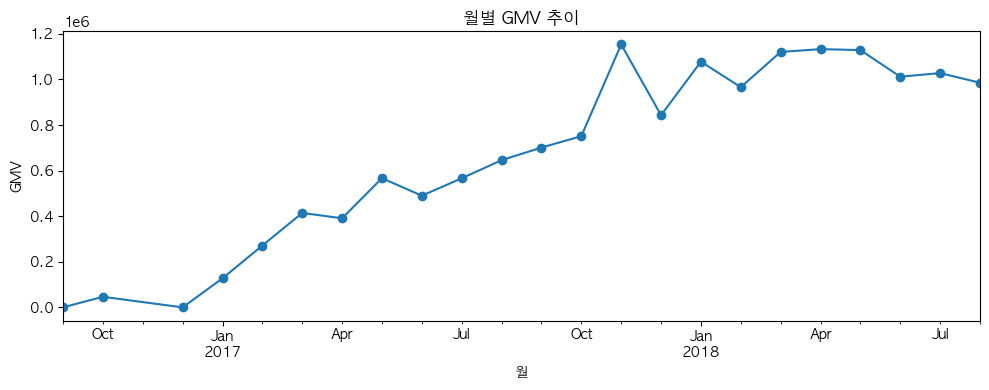

In [91]:
# 1. 월별 GMV 추이
import os
img_dir = '../images'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

fig, ax = plt.subplots(figsize=(10, 4))
monthly_gmv.plot(kind='line', marker='o', ax=ax)
ax.set_title('월별 GMV 추이')
ax.set_xlabel('월')
ax.set_ylabel('GMV')
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'q1_monthly_gmv.png'), dpi=180, bbox_inches='tight')
plt.show()

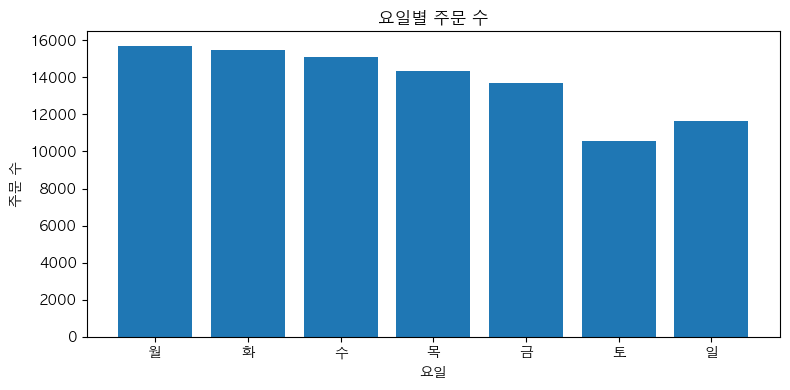

In [92]:
# 2. 요일별 주문 수
order_items_gmv['dow'] = order_items_gmv['order_purchase_timestamp'].dt.dayofweek
dow_labels = ['월', '화', '수', '목', '금', '토', '일']
dow_orders = order_items_gmv.groupby('order_id')['dow'].first().value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(dow_labels, dow_orders.values)
ax.set_title('요일별 주문 수')
ax.set_xlabel('요일')
ax.set_ylabel('주문 수')
plt.tight_layout()
plt.show()

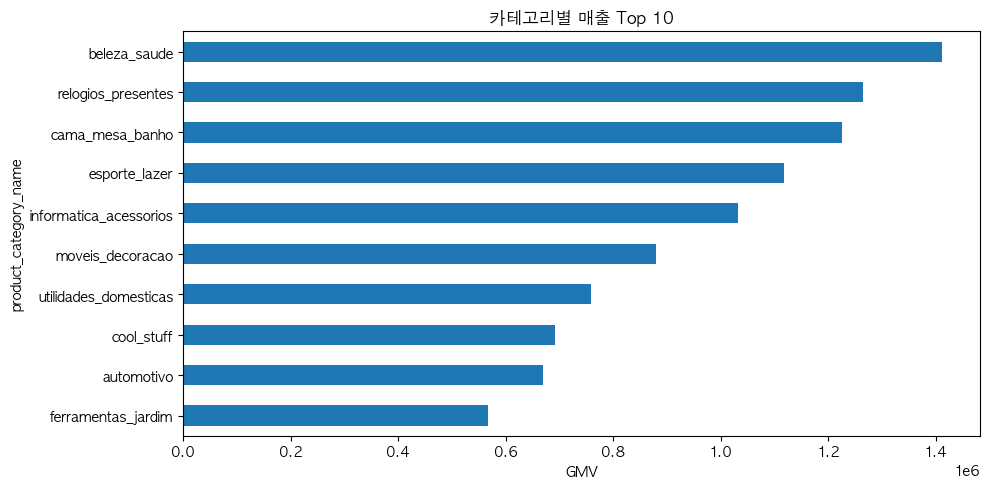

In [93]:
# 3. 카테고리별 매출 상위 10개
items_with_category = order_items_gmv.merge(products[['product_id', 'product_category_name']], on='product_id', how='left')
category_gmv = items_with_category.groupby('product_category_name')['gmv'].sum().sort_values(ascending=False).head(10)

fig, ax = plt.subplots(figsize=(10, 5))
category_gmv.plot(kind='barh', ax=ax)
ax.set_title('카테고리별 매출 Top 10')
ax.set_xlabel('GMV')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

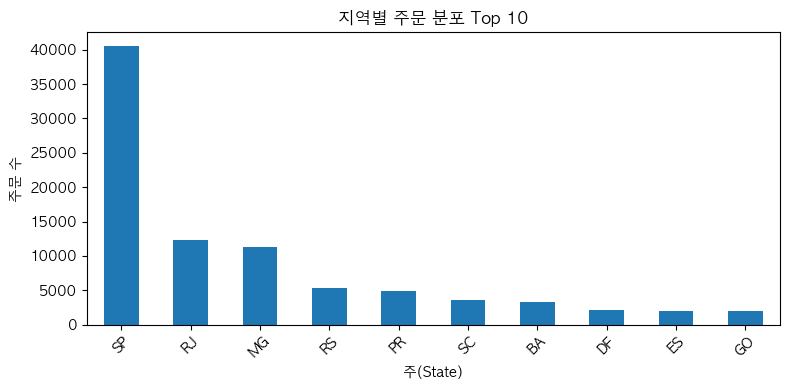

In [94]:
# 4. 지역별 주문 분포 (상위 10개 주)
orders_with_state = delivered_orders.merge(orders[['order_id', 'customer_id']], on='order_id', how='left')
orders_with_state = orders_with_state.merge(customers[['customer_id', 'customer_state']], on='customer_id', how='left')
state_orders = orders_with_state.groupby('customer_state').size().sort_values(ascending=False).head(10)

fig, ax = plt.subplots(figsize=(8, 4))
state_orders.plot(kind='bar', ax=ax)
ax.set_title('지역별 주문 분포 Top 10')
ax.set_xlabel('주(State)')
ax.set_ylabel('주문 수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

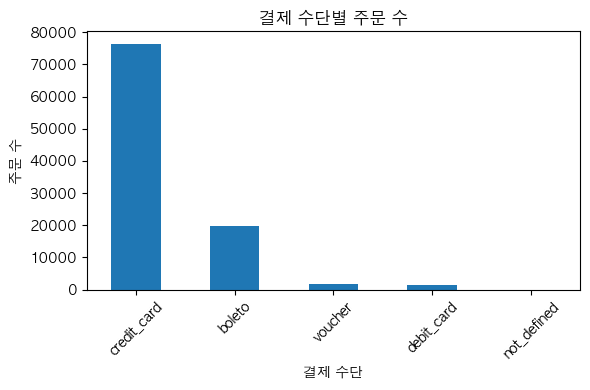

In [95]:
# 5. 결제 수단별 주문 비중
payment_orders = order_payments[order_payments['payment_sequential'] == 1]  # 주 결제수단만
payment_dist = payment_orders['payment_type'].value_counts()

fig, ax = plt.subplots(figsize=(6, 4))
payment_dist.plot(kind='bar', ax=ax)
ax.set_title('결제 수단별 주문 수')
ax.set_xlabel('결제 수단')
ax.set_ylabel('주문 수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 7. README용 대표 시각화

아래 시각화는 README에 삽입될 대표 시각화이다.
생성된 이미지는 `/images` 폴더에 저장된다.

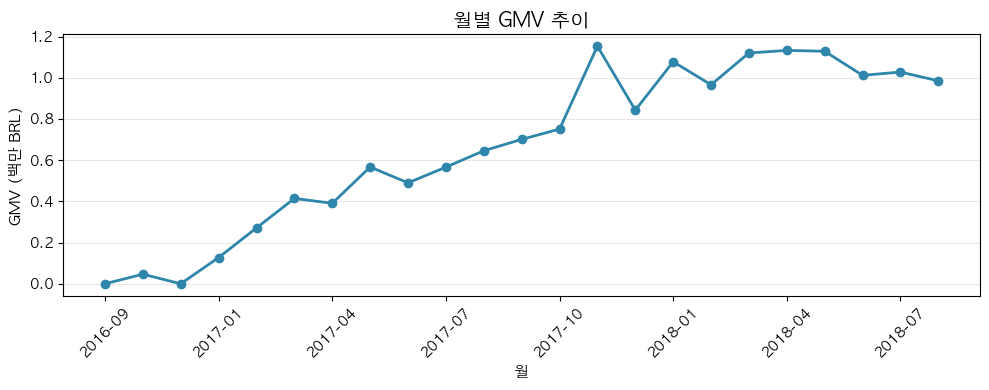

In [96]:
# Q1. 월별 GMV 추이 

import os
img_dir = '../images'
os.makedirs(img_dir, exist_ok=True)

# delivered 주문 필터링
delivered_orders_readme = orders[orders['order_status'] == 'delivered'][['order_id', 'order_purchase_timestamp']]
delivered_orders_readme['order_purchase_timestamp'] = pd.to_datetime(delivered_orders_readme['order_purchase_timestamp'])

order_items_readme = order_items.merge(delivered_orders_readme, on='order_id', how='inner')
order_items_readme['gmv'] = order_items_readme['price'] + order_items_readme['freight_value']
order_items_readme['year_month'] = order_items_readme['order_purchase_timestamp'].dt.to_period('M')

monthly_gmv_readme = order_items_readme.groupby('year_month')['gmv'].sum()

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(monthly_gmv_readme.index.astype(str), monthly_gmv_readme.values / 1e6, marker='o', linewidth=2, color='#2E86AB')
ax.set_title('월별 GMV 추이', fontsize=14, fontweight='bold')
ax.set_xlabel('월', fontsize=11)
ax.set_ylabel('GMV (백만 BRL)', fontsize=11)
ax.set_xticks(monthly_gmv_readme.index.astype(str)[::3])
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'q1_monthly_gmv.png'), dpi=150, facecolor='white')
plt.show()



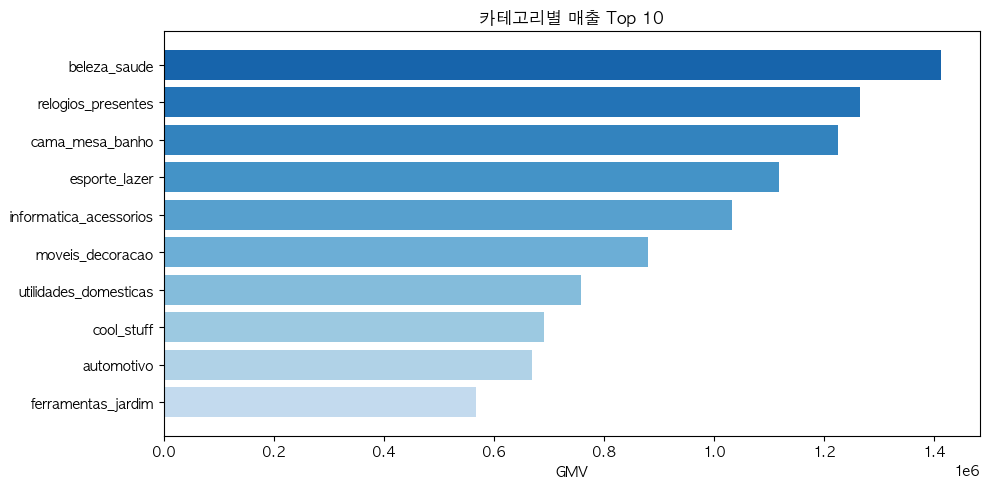

In [97]:
# 3. 카테고리별 매출 Top 10

items_with_cat = order_items_gmv.merge(products[['product_id', 'product_category_name']], on='product_id', how='left')
cat_gmv = items_with_cat.groupby('product_category_name')['gmv'].sum().sort_values(ascending=False).head(10)

fig, ax = plt.subplots(figsize=(10, 5))
colors = plt.cm.Blues_r([0.2 + 0.06 * i for i in range(10)])
ax.barh(cat_gmv.index[::-1], cat_gmv.values[::-1], color=colors[::-1])
ax.set_title('카테고리별 매출 Top 10')
ax.set_xlabel('GMV')
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'q3_top_categories.png'), dpi=180, bbox_inches='tight')
plt.show()

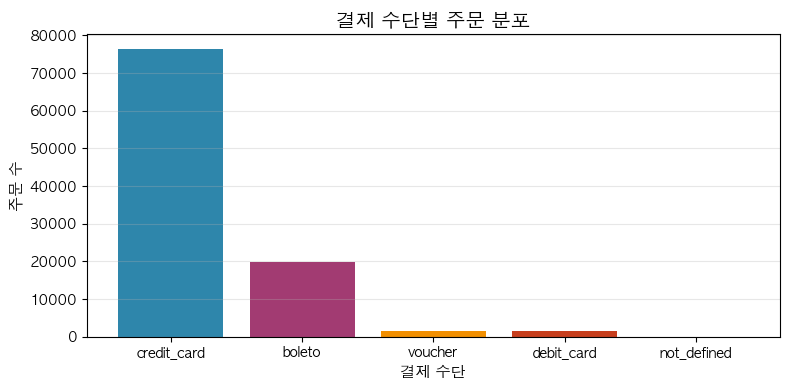

In [98]:
# Q5. 결제 수단별 주문 분포 

payment_primary_readme = order_payments[order_payments['payment_sequential'] == 1]
payment_type_readme = payment_primary_readme['payment_type'].value_counts()

fig, ax = plt.subplots(figsize=(8, 4))
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3B1F2B']
ax.bar(payment_type_readme.index, payment_type_readme.values, color=colors[:len(payment_type_readme)])
ax.set_title('결제 수단별 주문 분포', fontsize=14, fontweight='bold')
ax.set_xlabel('결제 수단', fontsize=11)
ax.set_ylabel('주문 수', fontsize=11)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'q5_payment_type_share.png'), dpi=150, facecolor='white')
plt.show()



## 8. Notebook 범위 명시

이 노트북은 데이터 구조 이해와 계산 검증을 목적으로 하며,
분석 결과의 해석 및 인사이트는 README 문서에 정리하였다.

In [99]:
# 연결 종료
conn.close()